In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [55]:
spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 20.0,
    },}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dconst.CORA_FULL,
    },
    # **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    
print(config.run.use_default_configuration)

True


In [56]:
config.model

ModelConfiguration(hidden_sizes=[64], linear_classification=False, weight_scale=1.0, use_spectral_norm=False, model_type='gcn', use_bias=False, activation='leaky_relu', leaky_relu_slope=0.01, residual=False, residual_pre_activation=True, freeze_residual_projection=False, dropout=0.0, drop_edge=0.0, use_spectral_norm_on_last_layer=False, use_bjorck_norm_on_last_layer=False, use_forbenius_norm_on_last_layer=False, use_rescaling_on_last_layer=False, use_residual_on_last_layer=False, use_rescaling=False, cached=True, self_loop_fill_value=1.0, use_forbenius_norm=False, use_bjorck_norm=False, forbenius_norm=1.0, initialization_scale=1.0, reconstruction=ReconstructionConfiguration(loss_weight=0.0, sample=True, num_samples=100, seed=1337, reconstruction_type='autoencoder', cached=True, margin_constrastive_loss=0.0), feature_reconstruction=FeatureReconstructionConfiguration(loss_weight=0.0, loss='l2', mirror_encoder=True, activation_on_last_layer=False, log_metrics_every=1, num_samples=-1, seed

In [57]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [58]:
model_seed = next(model_seed_generator)

In [59]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'ood-scattering')

In [60]:
config.run.use_pretrained_model

True

In [61]:
if not torch.cuda.is_available():
    config.training.gpus = 0
config.training.gpus = 0

In [62]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])) 
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=8710, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=7, bias=False)
          )
      )
    )
  )
)



  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 557 K 
----------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.232     Total estimated model params size (MB)
Global seed set to 1952926171


In [63]:
model = Ensemble([model], config.ensemble.num_samples, sample_at_eval=config.evaluation.sample)
model.clear_and_disable_cache()

In [64]:
model = model.eval()

In [65]:
from data.transform import PerturbationTransform

In [66]:
data_ood_val_ber = PerturbationTransform(noise_type='bernoulli', p=.5)(data_loaders[dconst.OOD_VAL].dataset[0])

In [67]:

data_train, data_val = data_loaders[dconst.TRAIN].dataset[0], data_loaders[dconst.VAL].dataset[0]
with torch.no_grad():
    pred_train = model(data_train)
    pred_val = model(data_val)


In [68]:
density_model = get_density_model(
    density_type='GaussianPerClass',
    covariance='diag',
    regularization=False,
    fit_val=True,
)
density_model.fit(
    pred_train.get_features(-2)[data_train.mask], 
    pred_train.get_predictions()[data_train.mask], 
    pred_val.get_features(-2)[data_val.mask],
    pred_val.get_predictions()[data_val.mask],
)

In [69]:
with torch.no_grad():
    features_ood_val = model(data_ood_val_ber).get_features(-2)
    density_ood_val = density_model(features_ood_val)

In [70]:
roc_auc_score(
    (~data_ood_val_ber.is_out_of_distribution).cpu().numpy()[data_ood_val_ber.mask],
    density_ood_val.cpu().numpy()[data_ood_val_ber.mask],
)

0.5686158063042486

## Different p for Bernoulli

In [79]:
ps, aurocs_density = [], []
aurocs_max_score = []

for p in tqdm(np.linspace(0.0, 1.0, 100)):
    for _ in range(10):
        data_p = PerturbationTransform(noise_type='bernoulli', p=p, seed=np.random.randint(0xFFFFFF))(data_loaders[dconst.OOD_VAL].dataset[0])
        ps.append(p)
        with torch.no_grad():
            pred_p = model(data_p)
            density_p = density_model(pred_p.get_features(-2))
            aurocs_density.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                density_p.cpu().numpy()[data_p.mask],
            ))
            aurocs_max_score.append(roc_auc_score(
                (~data_p.is_out_of_distribution).cpu().numpy()[data_p.mask],
                pred_p.get_predictions().cpu().numpy().max(axis=1)[data_p.mask],
                
            ))
            
        
    
    

100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


In [82]:
avg_sparsity = ((data_loaders[dconst.TRAIN].dataset[0].x > 0).sum(1) / data_loaders[dconst.TRAIN].dataset[0].x.size(1)).mean()
max_sparsity = ((data_loaders[dconst.TRAIN].dataset[0].x > 0).sum(1) / data_loaders[dconst.TRAIN].dataset[0].x.size(1)).max()

(array([ 141.,  549., 1048.,  709.,  232.,   75.,   30.,   14.,    8.,
           4.]),
 array([0.00022962, 0.00244546, 0.00466131, 0.00687715, 0.009093  ,
        0.01130884, 0.01352468, 0.01574053, 0.01795637, 0.02017222,
        0.02238806], dtype=float32),
 <BarContainer object of 10 artists>)

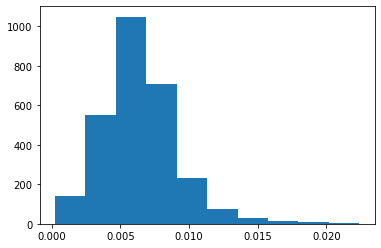

In [89]:
instance_sparsity = (data_loaders[dconst.TRAIN].dataset[0].x > 0).sum(1) / data_loaders[dconst.TRAIN].dataset[0].x.size(1)
fig, ax = plt.subplots()
ax.hist(instance_sparsity.cpu().numpy())

Text(0, 0.5, 'AUC-ROC')

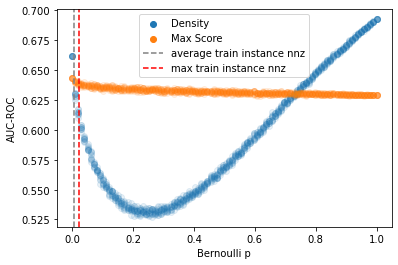

In [86]:
fig, ax = plt.subplots()
ax.scatter(ps, aurocs_density, alpha=.1, c='tab:blue')
ax.scatter([], [], label='Density', c='tab:blue')
ax.scatter(ps, aurocs_max_score, alpha=.1, c='tab:orange')
ax.scatter([], [], label='Max Score', c='tab:orange')
ax.axvline(avg_sparsity, ls='--', label='average train instance nnz', c='grey')
ax.axvline(max_sparsity, ls='--', label='max train instance nnz', c='red')
ax.legend()
ax.set_xlabel('Bernoulli p')
ax.set_ylabel('AUC-ROC')

In [74]:
aurocs

[0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6621059844677936,
 0.6290315212425766,
 0.628643216080402,
 0.6306532663316583,
 0.631521242576519,
 0.6306075833714024,
 0.6253312014618547,
 0.6332571950662402,
 0.6290772042028324,
 0.6288259479214253,
 0.6272042028323436,
 0.613522156235724,
 0.6132252169940613,
 0.6136135221562358,
 0.6161032434901781,
 0.6152581087254454,
 0.6162859753312016,
 0.6149383280036546,
 0.6146642302421197,
 0.6134993147555962,
 0.6182503426222019,
 0.6046139789858382,
 0.6006624029237094,
 0.6021699406121517,
 0.6010050251256281,
 0.603905893101873,
 0.6008451347647328,
 0.5997487437185929,
 0.6030835998172681,
 0.6039744175422568,
 0.6008679762448607,
 0.5935587026039287,
 0.5883280036546369,
 0.5900639561443581,
 0.592188213796254,
 0.5915943353129283,
 0.5928277752398355,
 0.5879853814527182,
 0.595957058017359

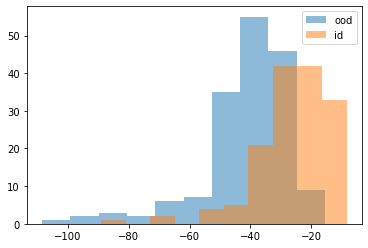

In [22]:
fig, ax = plt.subplots()
ax.hist(density_ood_val[data_ood_val_ber.mask & data_ood_val_ber.is_out_of_distribution].numpy(), label='ood', alpha=.5)
ax.hist(density_ood_val[data_ood_val_ber.mask & ~data_ood_val_ber.is_out_of_distribution].numpy(), label='id', alpha=.5)
ax.legend()

In [49]:
from umap import UMAP

proj = UMAP(random_state = 1337)
proj.fit(torch.cat([
    pred_train.get_features(-2)[data_train.mask],
    pred_val.get_features(-2)[data_val.mask],
    features_ood_val[data_ood_val_ber.mask]
], 0).numpy())

UMAP(random_state=1337, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [54]:
emb_train = proj.transform(pred_train.get_features(-2)[data_train.mask].numpy())
emb_val = proj.transform(pred_train.get_features(-2)[data_val.mask].numpy())
emb_val_ood_id = proj.transform(features_ood_val[data_ood_val_ber.mask & ~data_ood_val_ber.is_out_of_distribution])
emb_val_ood_ood = proj.transform(features_ood_val[data_ood_val_ber.mask & data_ood_val_ber.is_out_of_distribution])

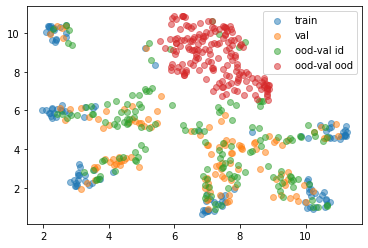

In [55]:
fig, ax = plt.subplots()
ax.scatter(emb_train[:, 0], emb_train[:, 1], label='train', alpha=.5)
ax.scatter(emb_val[:, 0], emb_val[:, 1], label='val', alpha=.5)
ax.scatter(emb_val_ood_id[:, 0], emb_val_ood_id[:, 1], label='ood-val id', alpha=.5)
ax.scatter(emb_val_ood_ood[:, 0], emb_val_ood_ood[:, 1], label='ood-val ood', alpha=.5)
ax.legend()

In [16]:
from tqdm import tqdm

deviations_id, deviations_ood = {}, {}

with torch.no_grad():

    features = model(data_ood_val_ber).get_features(-2)
    for eps in tqdm(np.logspace(-15, 0, 200)):
        data_per = data_ood_val_ber.clone()
        
        data_per.x += torch.randn(*data_per.x.size()) * eps
        features_eps = model(data_per).get_features(-2)

        delta_in = torch.norm(data_per.x - data_ood_val_ber.x, p=2, dim=1)
        delta = torch.norm(features_eps - features, p=2, dim=1)
        deviations_id[eps] = delta[~data_per.is_out_of_distribution].numpy(), delta_in[~data_per.is_out_of_distribution].numpy()
        deviations_ood[eps] = delta[data_per.is_out_of_distribution].numpy(), delta_in[data_per.is_out_of_distribution].numpy()
        

    
    
    

100%|██████████| 200/200 [00:24<00:00,  8.12it/s]


In [17]:
data_per.x[data_per.is_out_of_distribution]

tensor([[ 0.0139, -1.3328, -0.1802,  ...,  1.1912, -0.0905, -0.9312],
        [-0.5753,  0.4886,  0.7534,  ...,  0.0365,  0.9551,  0.0354],
        [ 0.5771,  0.4777,  0.5010,  ...,  0.1490,  0.2332, -0.7480],
        ...,
        [-0.1618, -0.2355, -0.9837,  ...,  0.2402, -0.2632, -0.1351],
        [ 0.3607,  1.1464,  0.5512,  ...,  1.1009,  0.1866, -0.6766],
        [ 0.2752,  0.2460, -1.6554,  ..., -0.4291,  1.4141, -0.9573]])

In [18]:
x_id, y_id = [], []
for eps, (dev_out, dev_in) in deviations_id.items():
    y_id += dev_out.tolist()
    x_id += dev_in.tolist()

x_ood, y_ood = [], []
for eps, (dev_out, dev_in) in deviations_ood.items():
    y_ood += dev_out.tolist()
    x_ood += dev_in.tolist()

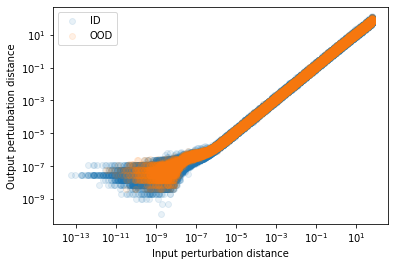

In [19]:
fig, ax = plt.subplots()
ax.scatter(x_id, y_id, alpha=.1, label='ID')
ax.scatter(x_ood, y_ood, alpha=.1, label='OOD')
ax.set_xlabel('Input perturbation distance')
ax.set_ylabel('Output perturbation distance')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

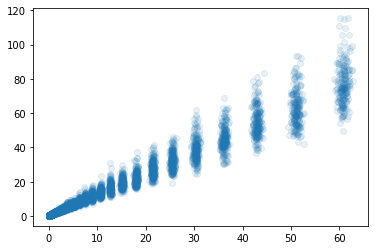

In [20]:
plt.scatter(x_ood, y_ood, alpha=.1)

In [21]:
deviations_ood

{1e-15: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.], dtype=float32),
  array([4.1891732e-14, 4.3

In [22]:
eps = 1e-2
data_per = data_ood_val_ber.clone()
data_per.x = data_ood_val_ber.x.clone()
data_per.x[...] = 5

In [23]:
data_ood_val_ber.x[data_ood_val_ber.is_out_of_distribution.numpy()]

tensor([[0.0000, 0.0000, 0.0231,  ..., 0.0231, 0.0231, 0.0000],
        [0.0233, 0.0000, 0.0000,  ..., 0.0000, 0.0233, 0.0233],
        [0.0231, 0.0000, 0.0000,  ..., 0.0000, 0.0231, 0.0000],
        ...,
        [0.0000, 0.0233, 0.0000,  ..., 0.0233, 0.0233, 0.0233],
        [0.0233, 0.0000, 0.0233,  ..., 0.0233, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0232,  ..., 0.0000, 0.0000, 0.0232]])

In [24]:
data_per.x

tensor([[5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        ...,
        [5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.]])

In [25]:
pred = model(data_loaders[dconst.OOD_VAL].dataset[0])

In [26]:
features = pred.get_features(-2)
predictions = pred.get_predictions()

In [27]:
features.size(), predictions.size()

(torch.Size([2110, 64]), torch.Size([2110, 6]))

In [28]:
predictions.sum(1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)